![alt text](images/lol.png "Title")





https://www.leagueoflegends.com/en-us/how-to-play/

### Détails du sujet

Ce jeu de données est un ensemble de data de League of Legends sur les matchs compétitifs. 
Si vous ne connaissez pas League of Legends, il s'agit d'un jeu où deux équipes de 5 joueurs s'affrontent. Chaque joueur choisi un champion, qui est un personnage parmi une liste. La partie d'arrête quand une équipe a détruit le nexus adverse. 

Le jeu expliqué en trois minutes : https://www.youtube.com/watch?v=OfYU4gbk13w

Chargez le dataset et répondez aux questions sous forme de phrase. 
Vous pouvez utiliser print(f"{}") pour rédiger des réponses complètes. 

Exemple : 

resultat = NombredeMort()

print(f"Le nombre de mort dans la partie est de {resultat}.")



Si vous avez des questions : 

                - Discord : @T.Bellanger (Salon Aide Prof sur le serveur 3A)

                - Teams : Thibaut Bellanger

                - Mail : thibaut.bellanger@esiea.fr

##### Import

In [2]:
#import 
import pandas as pd
from tqdm import tqdm
import hvplot.pandas
import holoviews as hv, colorcet as cc
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
from tqdm import tqdm
import matplotlib.pyplot as plt
hv.extension('bokeh')
import datashader as ds
import datashader.transfer_functions as tf
from holoviews.operation.datashader import rasterize
import numpy as np
import ast

C:\Users\asgri\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Découverte du dataset

#### Chargement du dataset

In [3]:
# Get the number of lines of the csv file
num_lines = sum(1 for l in open("data/leagueoflegends.csv"))

# Initialize a tqdm progress bar
pbar = tqdm(total=num_lines, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

# Read the csv file in chunks and update the progress bar after each chunk is processed
chunks = pd.read_csv("data/leagueoflegends.csv", sep=";", low_memory=False, chunksize=10000, iterator=True, encoding='utf-8')
df = []
for chunk in chunks:
    df.append(chunk)
    pbar.update(chunk.shape[0])

df = pd.concat(df, ignore_index=True)

# Close the progress bar
pbar.close()

if df is not None:
    print("Le dataset a bien été chargé.")


100%|█████████▉| 2201706/2201707

Le dataset a bien été chargé.


In [50]:
# Filtre 
ds = df

# Filtre d'adresse
df_Adress = df['Address']


# Flitre des données par année
df_2017 = df[df['Year'] == 2017]
df_2018 = df[df['Year'] == 2018]
df_saison_Spring = df[df['Season'] == 'Spring']
df_saison_Summer = df[df['Season'] == 'Summer']

# Filtre des données par Ban
df_BleuTeamBan = df[df['Team_bans'] == 'blue']
df_RedTeamBan = df[df['Team_bans'] == 'red']

# Filtre des données par Tag (ex: FNC, UOL, ...)
df_BleuTeamTag = df['blueTeamTag']
df_RedTeamTag = df['redTeamTag']

# Filtre des données par Position
df_PositionADC = df.groupby(['redADC', 'blueADC'])
df_PositionTOP = df.groupby(['redTop', 'blueTop'])
df_PositionMID = df.groupby(['blueMiddle', 'redMiddle'])
df_PositionJUNGLE = df.groupby(['redJungle', 'blueJungle'])
df_PositionSUPPORT = df.groupby(['redSupport', 'blueSupport'])

# Friltre des données par Kills
df_Killer = df['Killer']
df_Victim = df['Victim']
df_TimeKills = df['Time_kills']
df_Death_xpos = df['x_pos_kills']
df_Death_ypos = df['y_pos_kills']

# Filtre des données par Gold
df_BleuGold = df[df['Type_gold'] == 'goldbleu']
df_RedGold = df[df['Type_gold'] == 'goldred']
df_GoldPerMin = df['Gold_per_min']




print("Les filtres ont bien été appliqués.")

Les filtres ont bien été appliqués.


#### Afficher les 2 premières lignes

In [51]:
df.head(2)

,Address,Team_bans,ban_1,ban_2,ban_3,ban_4,ban_5,Type_gold,Gold_per_min,Team_kills,...,redTop,redTopChamp,redJungle,redJungleChamp,redMiddle,redMiddleChamp,redADC,redADCChamp,redSupport,redSupportChamp
0,http://matchhistory.na.leagueoflegends.com/en/...,blue,Rengar,Olaf,Janna,Nautilus,Poppy,golddiff,"[0.0, 0.0, 20.0, 209.0, -31.0, 37.0, -38.0, -1...",blue,...,Impact,Shen,Contractz,Khazix,Jensen,Fizz,Sneaky,Ashe,Smoothie,MissFortune
1,http://matchhistory.na.leagueoflegends.com/en/...,blue,Rengar,Olaf,Janna,Nautilus,Poppy,golddiff,"[0.0, 0.0, 20.0, 209.0, -31.0, 37.0, -38.0, -1...",blue,...,Impact,Shen,Contractz,Khazix,Jensen,Fizz,Sneaky,Ashe,Smoothie,MissFortune


#### Il y a-t-il des valeurs manquantes ? 

In [52]:
if df_2017.isnull().values.any():
    print("Il y a des valeurs manquantes.")
else:
    print("Il n'y a pas de valeurs manquantes.")

Il n'y a pas de valeurs manquantes.


#### Il y a-t-il des doublons ? 

In [53]:
if df_2017.duplicated().values.any():
    print("Il y a des doublons.")
else:
    print("Il n'y a pas de doublons.")

Il n'y a pas de doublons.


#### Ce dataset a une forme particulière. Le champ Address sert d'ID unique pour chaque partie. 

#### Combien de parties différentes contient ce dataset ? 

In [54]:
print(f"Ce dataset contient {df_Adress.nunique()} parties différentes.")

Ce dataset contient 3488 parties différentes.


    Vous devez répondre avec une phrase pour chaque question, n'affichez pas seulement un résultat, répondez à la question !

Au cours d'une partie, plusieurs évènements se produisent. Les joueurs s'éliminent plusieurs fois par exemple. Nous ne pouvons pas savoir à l'avance combien de "Victim" nous aurons dans une partie, et ce pour chaque partie, donc les lignes sont multipliées. 

Voici un exemple: 
    
| Partie_ID  | Victim          | Killer | Time_kills|
| :--------------- |:---------------:| -----:| ----:|
| game_1  |   UOL Hylissang    |  FNC Rekkles | 3 |
| game_1  | UOL Hylissang      |   FNC Rekkles | 5 |
| game_1  | UOL Hylissang      |    FNC Rekkles | 8 |
| game_2  | FNC Rhobalas              |   Trayton | 6 |
| game_2  | FNC Rhobalas          |    Trayton | 15 |
| game_2  | Chap          |    Trayton | 17 |
| game_2  | Chap             |   Trayton | 21 |

Dans cet exemple, sur la première partie (game_1), UOL Hylissang est mort 3 fois dans la partie, tué à chaque fois par FNC Rekkles. Time_kills indique le temps dans le jeu en minutes où le joueur est mort.  


Voici un deuxième exemple: 
    
| Partie_ID  | Victim          | Killer | Time_kills| Gold_type| Gold |
| :----------|:---------------:| ------:| ----:|  ----:| ----:| 
| game_1     | UOL Hylissang   | FNC Rekkles | 3 | Gold_blue | 5k |
| game_1     | UOL Hylissang   | FNC Rekkles | 3 | Gold_red | 4.9k |
| game_1     | UOL Hylissang   | FNC Rekkles | 5 | Gold_blue | 7k |
| game_1     | UOL Hylissang   | FNC Rekkles | 5 | Gold_red | 7.2k |
| game_2     | FNC Rhobalas    | Trayton | 6 | Gold_blue | 7.5k |
| game_2     | FNC Rhobalas    | Trayton | 6 | Gold_red | 7.5k |
| game_2     | FNC Rhobalas    | Trayton | 15 | Gold_blue | 15k |
| game_2     | FNC Rhobalas    | Trayton | 15 | Gold_red | 16k |

Dans ce deuxième exemple, si vous comptez le nombre de mort de FNC Rhobalas, vous aurez des doublons ! Certains colonnes servent de "filtres", ce qui évitent d'avoir trop de colonnes mais ce qui rajoute des lignes.  

    Attention donc aux doublons, en considérant les données utiles pour chaque question ! 

### Combien d'équipes différentes il y a-t-il ? 

In [55]:
groupe = df.groupby(['blueTeamTag', 'redTeamTag'])
print(f"Il y a {groupe.ngroups} équipes différentes.")


Il y a 1152 équipes différentes.


### Quel joueur est mort le plus de fois ?

In [56]:
# Group the DataFrame 'df' by 'Victim' and 'Time_kills' columns. This operation will create a new DataFrame where each unique combination of 'Victim' and 'Time_kills' will be a separate group.
df_Victim = df.groupby(['Victim' , 'Time_kills'])

# Convert the grouped DataFrame to a new DataFrame where each group is a row and the value is the size of the group. This operation will create a DataFrame where each row represents a unique combination of 'Victim' and 'Time_kills' and the value is the count of occurrences of this combination in the original DataFrame.
df_Victim = pd.DataFrame(df_Victim.size())

# Get the 'Victim' values from the index of the DataFrame. This operation will create a Series where each value is the 'Victim' part of the index of the DataFrame 'df_Victim'.
df_Victim = df_Victim.index.get_level_values(0)


maxDeathPlayer = df_Victim.value_counts().idxmax()
print(f"{maxDeathPlayer} est le joueur qui est mort le plus de fois. Il est mort {df_Victim.value_counts().max()} fois.")

TSM Svenskeren est le joueur qui est mort le plus de fois. Il est mort 397 fois.


### A quel poste joue ce joueur ? 

In [57]:

# remove the tag of the player
maxDeathPlayer = maxDeathPlayer.split(' ')[1]


if(df['blueADC'].str.contains(maxDeathPlayer).any() or df['redADC'].str.contains(maxDeathPlayer).any()):
    print(f"{maxDeathPlayer} joue ADC.")
if(df['blueTop'].str.contains(maxDeathPlayer).any() or df['redTop'].str.contains(maxDeathPlayer).any()):
    print(f"{maxDeathPlayer} joue TOP.")
if(df['blueMiddle'].str.contains(maxDeathPlayer).any() or df['redMiddle'].str.contains(maxDeathPlayer).any()):
    print(f"{maxDeathPlayer} joue MID.")
if(df['blueJungle'].str.contains(maxDeathPlayer).any() or df['redJungle'].str.contains(maxDeathPlayer).any()):
    print(f"{maxDeathPlayer} joue JUNGLE.")
if(df['blueSupport'].str.contains(maxDeathPlayer).any() or df['redSupport'].str.contains(maxDeathPlayer).any()):
    print(f"{maxDeathPlayer} joue SUPPORT.")


Svenskeren joue JUNGLE.


### Quel joueur est mort le plus de fois en moyenne par partie ?

In [5]:
# Group the data by game and player (Victim)
grouped_df = df.groupby(['Address', 'Victim'])

# Count the number of deaths for each player in each game
deaths_per_game = grouped_df.size()

# Calculate the average number of deaths per game for each player
average_deaths = deaths_per_game.groupby('Victim').mean()

# Find the player with the highest average number of deaths per game
max_avg_deaths_player = average_deaths.idxmax()
max_avg_deaths_value = average_deaths.max()

print(f"{max_avg_deaths_player} is the player who died the most times on average per game. They died {max_avg_deaths_value} times on average.")

SUP Lethilion is the player who died the most times on average per game. They died 208.0 times on average.


### A quel poste joue ce joueur ? 

In [59]:
# remove the tag of the player
max_avg_deaths_player = max_avg_deaths_player.split(' ')[1]


if(df['blueADC'].str.contains(max_avg_deaths_player).any() or df['redADC'].str.contains(max_avg_deaths_player).any()):
    print(f"{max_avg_deaths_player} joue ADC.")
if(df['blueTop'].str.contains(max_avg_deaths_player).any() or df['redTop'].str.contains(max_avg_deaths_player).any()):
    print(f"{max_avg_deaths_player} joue TOP.")
if(df['blueMiddle'].str.contains(max_avg_deaths_player).any() or df['redMiddle'].str.contains(max_avg_deaths_player).any()):
    print(f"{max_avg_deaths_player} joue MID.")
if(df['blueJungle'].str.contains(max_avg_deaths_player).any() or df['redJungle'].str.contains(max_avg_deaths_player).any()):
    print(f"{max_avg_deaths_player} joue JUNGLE.")
if(df['blueSupport'].str.contains(max_avg_deaths_player).any() or df['redSupport'].str.contains(max_avg_deaths_player).any()):
    print(f"{max_avg_deaths_player} joue SUPPORT.")

Lethilion joue ADC.


### Quel champion a le plus haut winrate blueside (Taux de victoire)? Afficher la liste en cas d'égalité.

In [60]:

# Tri les Adresses pour evité les doublons
dl = df.sort_values(by='Address')

# Get only the games won by the blue team
dl_blue_win = dl[dl['bResult'] == 1]

# Initialize an empty list to store the win rates
win_rates = []

# Loop over each position
for position in ['blueTopChamp', 'blueJungleChamp', 'blueMiddleChamp', 'blueADCChamp', 'blueSupportChamp']:
    # Group the data by champion for the current position
    grouped_df_win = dl_blue_win.groupby(position)
    grouped_df_total = dl.groupby(position)

    # Count the number of games won and played by each champion
    blue_win_count = grouped_df_win.size()
    blue_played_count = grouped_df_total.size()

    # Calculate the win rate for each champion
    blue_win_rate = blue_win_count / blue_played_count

    # Add the win rates to the list
    win_rates.append(blue_win_rate)

# Concatenate all the win rates
win_rates_df = pd.concat(win_rates)

# Find the champion with the highest win rate
max_win_rate = win_rates_df.max()
champions = win_rates_df[win_rates_df == max_win_rate].index

print(f"The champions with the highest win rate on the blue side are: {', '.join(champions)} with a win rate of {max_win_rate}.")

The champions with the highest win rate on the blue side are: Karma, Kassadin, Malphite, Nocturne, Rengar, Zac, Bard, Draven, Ekko, Rammus, Akali, Camille, Fiora, Heimerdinger, Jhin, Karthus, Lissandra, Mordekaiser, Nunu, Swain, Varus, Veigar, Alistar, Heimerdinger, Irelia, Quinn, Ashe, Elise, Kalista, Lux, Zac with a win rate of 1.0.


### Quel champion a le plus haut winrate redside (Taux de victoire)? Afficher la liste en cas d'égalité.

In [61]:
# Tri les Adresses pour evité les doublons
dl = df.sort_values(by='Address')

# Get only the games won by the blue team
df_blue_win = dl[dl['rResult'] == 1]

# Initialize an empty list to store the win rates
win_rates = []

# Loop over each position
for position in ['redTopChamp', 'redJungleChamp', 'redMiddleChamp', 'redADCChamp', 'redSupportChamp']:
    # Group the data by champion for the current position
    grouped_df_win = df_blue_win.groupby(position)
    grouped_df_total = dl.groupby(position)

    # Count the number of games won and played by each champion
    blue_win_count = grouped_df_win.size()
    blue_played_count = grouped_df_total.size()

    # Calculate the win rate for each champion
    blue_win_rate = blue_win_count / blue_played_count

    # Add the win rates to the list
    win_rates.append(blue_win_rate)

# Concatenate all the win rates
win_rates_df = pd.concat(win_rates)

# Find the champion with the highest win rate
max_win_rate = win_rates_df.max()
champions = win_rates_df[win_rates_df == max_win_rate].index

print(
    f"The champions with the highest win rate on the blue side are: {', '.join(champions)} with a win rate of {max_win_rate}.")


The champions with the highest win rate on the blue side are: Graves, Nasus, Shaco, Tryndamere, XinZhao, Zed, Jax, Riven, Gangplank, Heimerdinger, Twitch, Varus, Karthus, Ashe, Maokai, Rengar, Vayne, Velkoz with a win rate of 1.0.


### Quel champion a le plus haut winrate (Taux de victoire)? 

In [62]:
# Tri les Adresses pour evité les doublons
dl = df.sort_values(by='Address')

# Get only the games won by the blue team and red team
df_blue_win = dl[dl['bResult'] == 1]
df_red_win = dl[dl['rResult'] == 1]

# Initialize an empty list to store the win rates
win_rates = []

# Loop over each position for both blue and red sides
for position in ['blueTopChamp', 'blueJungleChamp', 'blueMiddleChamp', 'blueADCChamp', 'blueSupportChamp',
                 'redTopChamp', 'redJungleChamp', 'redMiddleChamp', 'redADCChamp', 'redSupportChamp']:
    # Group the data by champion for the current position
    grouped_df_win = df_blue_win.groupby(position) if 'blue' in position else df_red_win.groupby(position)
    grouped_df_total = dl.groupby(position)

    # Count the number of games won and played by each champion
    win_count = grouped_df_win.size()
    played_count = grouped_df_total.size()

    # Calculate the win rate for each champion
    win_rate = win_count / played_count

    # Add the win rates to the list
    win_rates.append(win_rate)

# Concatenate all the win rates
win_rates_df = pd.concat(win_rates)

# Find the champion with the highest win rate
max_win_rate = win_rates_df.max()
champions = win_rates_df[win_rates_df == max_win_rate].index

print(f"The champions with the highest win rate are: {', '.join(champions)} with a win rate of {max_win_rate}.")

The champions with the highest win rate are: Karma, Kassadin, Malphite, Nocturne, Rengar, Zac, Bard, Draven, Ekko, Rammus, Akali, Camille, Fiora, Heimerdinger, Jhin, Karthus, Lissandra, Mordekaiser, Nunu, Swain, Varus, Veigar, Alistar, Heimerdinger, Irelia, Quinn, Ashe, Elise, Kalista, Lux, Zac, Graves, Nasus, Shaco, Tryndamere, XinZhao, Zed, Jax, Riven, Gangplank, Heimerdinger, Twitch, Varus, Karthus, Ashe, Maokai, Rengar, Vayne, Velkoz with a win rate of 1.0.


### Afficher une carte des kills en utilisant le package datashader (https://datashader.org/)

In [70]:


%%time
ds['x_pos_kills'] = pd.to_numeric(df['x_pos_kills'], errors='coerce')
ds['y_pos_kills'] = pd.to_numeric(df['y_pos_kills'], errors='coerce')

ds_XY = ds[['x_pos_kills', 'y_pos_kills']]
map_tiles = EsriImagery().opts(alpha=0.5, width=900, height=900, bgcolor='black')
points = hv.Points(ds_XY, ['x_pos_kills', 'y_pos_kills'])
ropts = dict(tools=['hover'], colorbar=True, colorbar_position='bottom', cmap=cc.fire, cnorm='eq_hist')
taxi_trips = rasterize(points).opts(**ropts)
map_tiles * taxi_trips




CPU times: total: 46.9 ms
Wall time: 46.6 ms


:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x_pos_kills,y_pos_kills]   (x_pos_kills_y_pos_kills Count)

### Combien de temps a duré la partie la plus courte ? Donnez la league, l'année, la saison, le type de match et les noms des équipes. 

In [64]:
# Find the ID of the shortest game
shortest_game_id = df['gamelength'].idxmin()

# Get the league, year, season, match type, and team names of the shortest game
shortest_game_league = df.loc[shortest_game_id, 'League']
shortest_game_year = df.loc[shortest_game_id, 'Year']
shortest_game_season = df.loc[shortest_game_id, 'Season']
shortest_game_match_type = df.loc[shortest_game_id, 'Type_match']
shortest_game_blue_team = df.loc[shortest_game_id, 'blueTeamTag']
shortest_game_red_team = df.loc[shortest_game_id, 'redTeamTag']

print(f"La partie la plus courte a duré {df.loc[shortest_game_id, 'gamelength']} minutes. Elle a eu lieu en {shortest_game_league} en {shortest_game_year} pendant la saison {shortest_game_season} et était un match de type {shortest_game_match_type} entre les équipes {shortest_game_blue_team} et {shortest_game_red_team}.")

La partie la plus courte a duré 17 minutes. Elle a eu lieu en TCL en 2017 pendant la saison Summer et était un match de type Season entre les équipes FB et CLK.


### Quelle partie a été la plus longue ?  Donnez la league, l'année, la saison, le type de match et les noms des équipes. 

In [65]:
# Find the ID of the shortest game
shortest_game_id = df['gamelength'].idxmax()

# Get the league, year, season, match type, and team names of the shortest game
shortest_game_league = df.loc[shortest_game_id, 'League']
shortest_game_year = df.loc[shortest_game_id, 'Year']
shortest_game_season = df.loc[shortest_game_id, 'Season']
shortest_game_match_type = df.loc[shortest_game_id, 'Type_match']
shortest_game_blue_team = df.loc[shortest_game_id, 'blueTeamTag']
shortest_game_red_team = df.loc[shortest_game_id, 'redTeamTag']

print(f"La partie la plus courte a duré {df.loc[shortest_game_id, 'gamelength']} minutes. Elle a eu lieu en {shortest_game_league} en {shortest_game_year} pendant la saison {shortest_game_season} et était un match de type {shortest_game_match_type} entre les équipes {shortest_game_blue_team} et {shortest_game_red_team}.")

La partie la plus courte a duré 95 minutes. Elle a eu lieu en LCK en 2018 pendant la saison Spring et était un match de type Season entre les équipes JAG et SKT.


### Affichez la courbe de golddiff de cette partie en précisant les tags d'équipes.
Vous devriez obtenir cette image : ![./images/gold_diff.png](./images/gold_diff.png "Title")

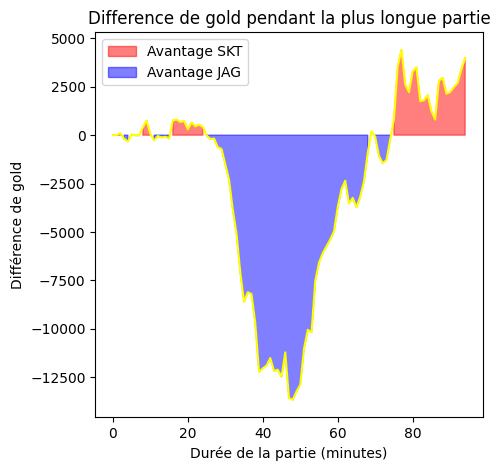

In [66]:

import numpy as np

# Find the ID of the longest game
longest_game_id = df['gamelength'].idxmax()

# Filter the original DataFrame to only include rows from the longest game
longest_game = df[df['Address'] == df.loc[longest_game_id, 'Address']]

# Get the list of Gold differences for each minute of the game
gold_diffPerMin = longest_game[longest_game['Type_gold'] == 'golddiff']['Gold_per_min']

# Convert the 'Gold_per_min' column to a list of numbers
gold_diffPerMin = gold_diffPerMin.apply(ast.literal_eval)

# Plot the Gold difference per minute
plt.figure(figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(gold_diffPerMin.iloc[0], color='yellow')  # Plot the first (and only) row

# Fill the area above and below zero with different colors
plt.fill_between(range(len(gold_diffPerMin.iloc[0])), gold_diffPerMin.iloc[0], where=np.array(gold_diffPerMin.iloc[0])>=0, color='red', alpha=0.5, label='Avantage SKT')
plt.fill_between(range(len(gold_diffPerMin.iloc[0])), gold_diffPerMin.iloc[0], where=np.array(gold_diffPerMin.iloc[0])<0, color='blue', alpha=0.5, label='Avantage JAG')

plt.title("Difference de gold pendant la plus longue partie")
plt.xlabel("Durée de la partie (minutes)")
plt.ylabel("Différence de gold")
plt.legend()
plt.show()

### Quel joueur est mort le plus vite dans une partie (Hors "TooEarly") ? Combien de temps a-t-il tenu ? 

In [67]:
df_TimeKillsWithoutTooEarly = df[df['Time_kills'] != 'TooEarly']
df_TimeKillsWithoutTooEarly['Time_kills'] = pd.to_numeric(df_TimeKillsWithoutTooEarly['Time_kills'], errors='coerce')

# Find the ID of the player who died the fastest
fastest_death_id = df_TimeKillsWithoutTooEarly['Time_kills'].idxmin()

# Get the player who died the fastest
fastest_death_player = df_TimeKillsWithoutTooEarly.loc[fastest_death_id, 'Victim']
fastest_death_time = df_TimeKillsWithoutTooEarly.loc[fastest_death_id, 'Time_kills']

# Transform the time from minutes to a more readable format
minutes = fastest_death_time*100 // 60
seconds = round(fastest_death_time*100 % 60, 2)

print(f"{fastest_death_player} est le joueur qui est mort le plus vite dans une partie. Il est mort après {minutes} minutes et {seconds} secondes.")

TooEarly est le joueur qui est mort le plus vite dans une partie. Il est mort après 1.0 minutes et 1.67 secondes.


# Question BONUS

### Quel joueur est celui ayant eu le plus de gold au cours d'une partie ? 

### Quel joueur a joué le plus de fois le même champion ? 

In [68]:
play_champ_groupe_Blue_Top = df.groupby(['blueTop', 'blueTopChamp']).size()
play_champ_groupe_Blue_Jungle = df.groupby(['blueJungle', 'blueJungleChamp']).size()
play_champ_groupe_Blue_Middle = df.groupby(['blueMiddle', 'blueMiddleChamp']).size()
play_champ_groupe_Blue_ADC = df.groupby(['blueADC', 'blueADCChamp']).size()
play_champ_groupe_Blue_Support = df.groupby(['blueSupport', 'blueSupportChamp']).size()

play_champ_groupe_Red_Top = df.groupby(['redTop', 'redTopChamp']).size()
play_champ_groupe_Red_Jungle = df.groupby(['redJungle', 'redJungleChamp']).size()
play_champ_groupe_Red_Middle = df.groupby(['redMiddle', 'redMiddleChamp']).size()
play_champ_groupe_Red_ADC = df.groupby(['redADC', 'redADCChamp']).size()
play_champ_groupe_Red_Support = df.groupby(['redSupport', 'redSupportChamp']).size()

play_champ_groupe = pd.concat([play_champ_groupe_Blue_Top, play_champ_groupe_Blue_Jungle, play_champ_groupe_Blue_Middle, play_champ_groupe_Blue_ADC, play_champ_groupe_Blue_Support, play_champ_groupe_Red_Top, play_champ_groupe_Red_Jungle, play_champ_groupe_Red_Middle, play_champ_groupe_Red_ADC, play_champ_groupe_Red_Support])

play_champ_groupe = play_champ_groupe.idxmax()

print(f"{play_champ_groupe[0]} est le joueur qui a joué le plus de fois le même champion {play_champ_groupe[1]}.")

Apollo est le joueur qui a joué le plus de fois le même champion Varus.
